# Environment Setup

In [153]:
#Installing Transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
#Installing TensorFlow
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
#Installing Tabulate
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
#Importing necessary packages

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from scipy import stats

from tabulate import tabulate
from tqdm import trange
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import re
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Dataset

In [157]:
#Extracting the dataset
df = pd.read_csv('/content/Final_Dataset.csv', index_col=False)   

In [158]:
#Viewing data
df.head(10)

,text,label
0,My girlfriend and I made Dwayne â€œThe Rockâ€...,negative
1,"There is no â€œopioid epidemicâ€ <a href=""http...",negative
2,This one goes out to the McDonaldâ€™s kids.,positive
3,how does a Benadryl trip(?) compare to an actu...,negative
4,Smoke a blunt with me ðŸƒ ðŸƒ âœ”ï¸ðŸ”¥,negative
5,Drugs are used as medicine to treat a wide ran...,positive
6,Many drugs are prescribed by doctors to help p...,positive
7,Antibiotics are a type of drug used to fight b...,positive
8,Antidepressants are drugs used to treat depres...,positive
9,Chemotherapy drugs are used to treat cancer.,positive


In [160]:
#Looking at the size of data
df.shape

(9444, 2)

# Exploratory Data Analysis

In [161]:
#Displaying information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9444 entries, 0 to 9443
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9443 non-null   object
 1   label   9443 non-null   object
dtypes: object(2)
memory usage: 147.7+ KB


* We see that there are no null values in our data





In [162]:
#Statistical summary of data
df.describe()

,text,label
count,9443,9443
unique,9017,2
top,Let's take some edibles and explore the city.,positive
freq,5,4870


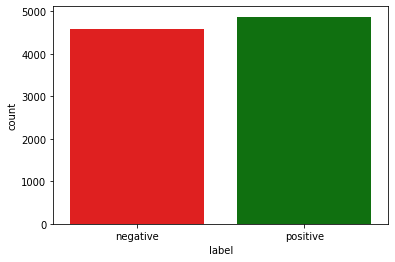

positive    4870
negative    4573
Name: label, dtype: int64


In [163]:
#Displaying the distribution of positive and negative labeled texts
sns.countplot(df['label'], palette = ["red","green"])
plt.show()
print(df.label.value_counts())

*   We see that the number of positive texts are slightly more than the negative texts.



In [164]:
#Converting labels from positive/negative to integer values
df.label = [ 1 if each == "positive" else 0 for each in df.label]

We convert the label to integer values:
 - positive --> 1 
 - negative --> 0 


In [165]:
#Extracting text and label values from data
text = df.text.values
label = df.label.values

In [166]:
#Diplaying dataframe post conversion
df.head()

,text,label
0,My girlfriend and I made Dwayne â€œThe Rockâ€...,0
1,"There is no â€œopioid epidemicâ€ <a href=""http...",0
2,This one goes out to the McDonaldâ€™s kids.,1
3,how does a Benadryl trip(?) compare to an actu...,0
4,Smoke a blunt with me ðŸƒ ðŸƒ âœ”ï¸ðŸ”¥,0


# Data Preprocessing

## Text Cleaning

In [167]:
#Importing Regular Expression module
import re

#Converting texts to str type to deal with garbage characters or Unicode replacement characters
df['text'] = df['text'].apply(lambda x: str(x))

#Displaying data post conversion to str
df.head()

,text,label
0,My girlfriend and I made Dwayne â€œThe Rockâ€...,0
1,"There is no â€œopioid epidemicâ€ <a href=""http...",0
2,This one goes out to the McDonaldâ€™s kids.,1
3,how does a Benadryl trip(?) compare to an actu...,0
4,Smoke a blunt with me ðŸƒ ðŸƒ âœ”ï¸ðŸ”¥,0


### Removing HTML strips and noise text




In [168]:
#Importing package for cleaning HTML code
from bs4 import BeautifulSoup

In [169]:
#Removing the HTML strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Applying function on text column
df['text']=df['text'].apply(denoise_text)

#Displaying data post removal of HTML strips and noise text
df.head()

,text,label
0,My girlfriend and I made Dwayne â€œThe Rockâ€...,0
1,There is no â€œopioid epidemicâ€ opiod crisis ...,0
2,This one goes out to the McDonaldâ€™s kids.,1
3,how does a Benadryl trip(?) compare to an actu...,0
4,Smoke a blunt with me ðŸƒ ðŸƒ âœ”ï¸ðŸ”¥,0


### Clearing punctuation and unnecessary marks in data
### Capitalization changed to lowercase
### Cleaning extra spaces

In [170]:
#Clearing punctuation & unnecessary marks
df['text'] = df['text'].apply(lambda x: re.sub('[,\.!?:()"]', ' ', x))
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#Capitalization changed to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

#Cleaning extra spaces
df['text'] = df['text'].apply(lambda x: x.strip())

#Displaying data post cleaning
df.head()

,text,label
0,my girlfriend and i made dwayne the rock ...,0
1,there is no opioid epidemic opiod crisis ...,0
2,this one goes out to the mcdonald s kids,1
3,how does a benadryl trip compare to an actu...,0
4,smoke a blunt with me,0


### Generating Word Frequencies


Generating a frequency table of all the words present in all the texts combined.

In [172]:
def gen_freq(text):
    
    #Stores all the words in a list
    words_list = []
    
    #Loops over all words and extracts words from list
    for word in text.split():
        words_list.extend(word)
        
    #Generates word frequencies using value counts in words_list
    word_freq = pd.Series(words_list).value_counts()
    
    #Prints top 100 words
    word_freq[:100]
    
    return word_freq

In [173]:
#Generating word frequencies
freq = gen_freq(df.text.str)

#Printing frequencies
freq

to          4789
the         4551
and         3702
i           3174
of          2954
            ... 
snakes         1
venomous       1
section        1
sale           1
st             1
Length: 6927, dtype: int64

*   We see that stopwords are most frequent, hence we remove stopwords



### Removing Stopwords

In [174]:
#Importing stopword module and creating a list of stopwords
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [175]:
#Importing packages for tokenization
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [176]:
#Tokenization of text
tokenizer=ToktokTokenizer()

In [177]:
#Removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Applying function on text column
df['text']= df['text'].apply(remove_stopwords)

###Generating Word Clouds after Cleaning Text

In [178]:
#Importing WordCloud library
from wordcloud import WordCloud

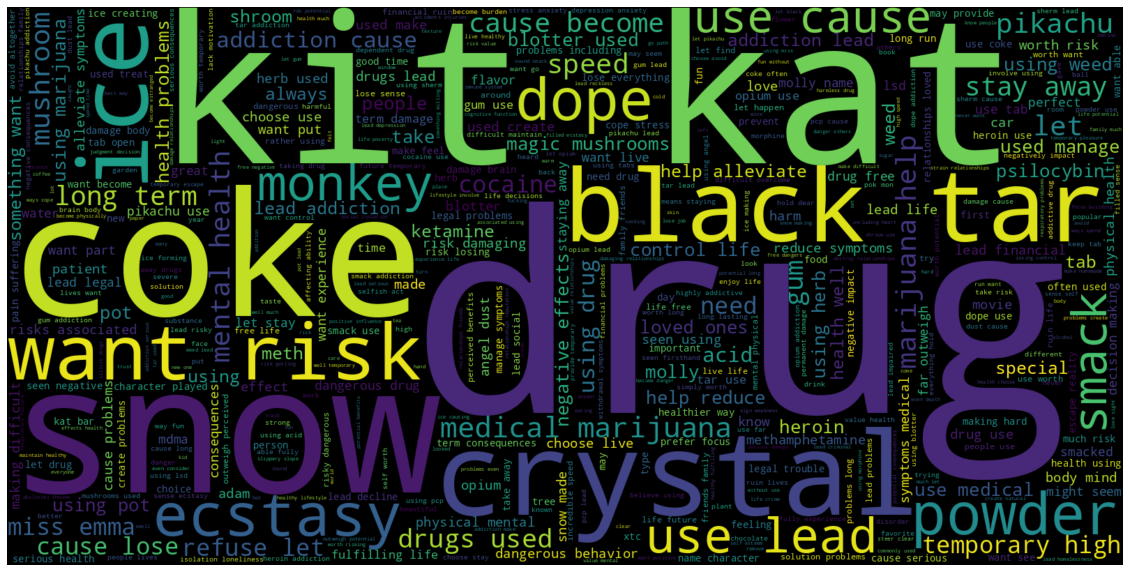

In [179]:
#Generating WordCloud for POSITIVE labeled texts
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               ).generate(" ".join(df[df.label == 1].text))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

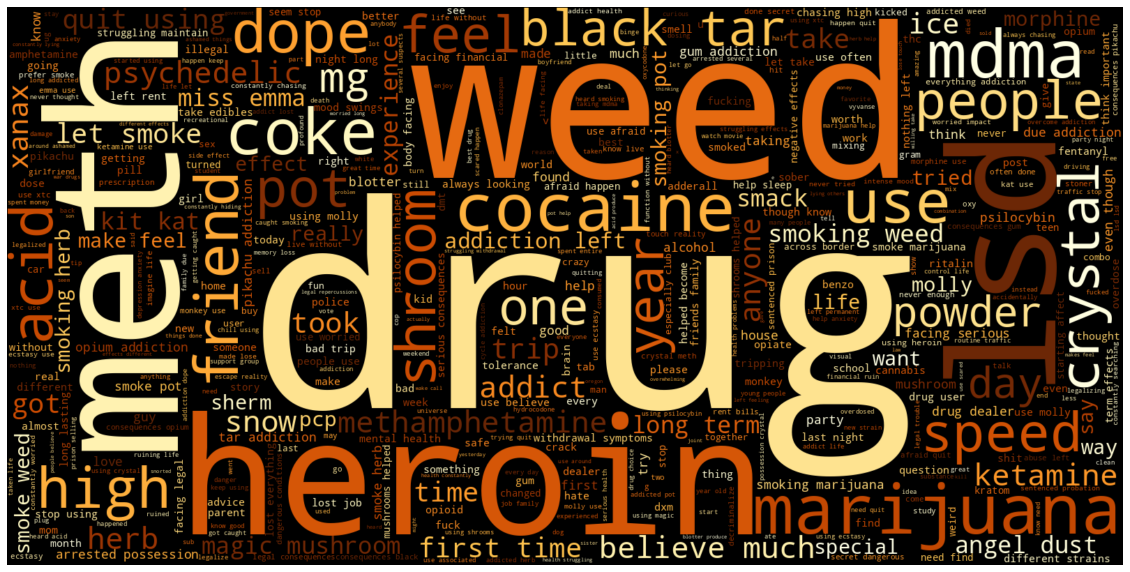

In [180]:
#Generating WordCloud for NEGATIVE labeled texts
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               ).generate(" ".join(df[df.label == 0].text))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

## Tokenization of Data

### Splitting texts into word-level tokens and mapping them to unique IDs in the BERT vocabulary using the BERT base model (uncased)

In [181]:
#Initializing tokenizer object using BertTokenizer class
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [182]:
#Verifying that tokenization process correctly splits text into individual words
def print_rand_sentence():
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

#Displaying tokens and respective IDs of a random text sample in tabulated form
print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ let      │        2292 │
├──────────┼─────────────┤
│ monkey   │       10608 │
├──────────┼─────────────┤
│ become   │        2468 │
├──────────┼─────────────┤
│ center   │        2415 │
├──────────┼─────────────┤
│ life     │        2166 │
├──────────┼─────────────┤
│ focus    │        3579 │
╘══════════╧═════════════╛


### Encoding Texts: Adding special tokens, padding to make sentences of same length

In [183]:
#Preprocessing: Encoding texts with tokenizer.encode_plus
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):

# preprocessing(input_text, tokenizer) returns the following fields:
#  - input_ids: list of token ids
#  - token_type_ids: list of token type ids
#  - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True)

  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 100, #Maximum length of input text
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

#Encoding each text in dataset
for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

#Concatenating all tensors
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(label)

In [185]:
#Displaying token ids for random sample
token_id[4]

tensor([  101,  5610, 14969,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [184]:
#Verifying output of tokenizer.encode_plus in tabulated form
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════════╤═════════════╤══════════════════╕
│ Tokens       │   Token IDs │   Attention Mask │
╞══════════════╪═════════════╪══════════════════╡
│ [CLS]        │         101 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ people       │        2111 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ reported     │        2988 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ experiencing │       13417 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ego          │       13059 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ death        │        2331 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ tab          │       21628 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ##s          │        2015 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ [SEP]        │         102 │                1 │


# Train-Validate-Test Split of Data

In [193]:
#Data split
test_ratio = 0.2

#Batch Size
batch_size = 32

#Indices of the train and test splits stratified by labels
train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size = test_ratio,
    shuffle = True,
    stratify = labels)

# Train and Test sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        labels[test_idx])

#Preparing DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [194]:
#Data split
val_ratio = 0.2

#Batch Size
batch_size = 32

#Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    train_idx,
    test_size = val_ratio,
    shuffle = True,
    stratify  = labels[train_idx])



#Train and Validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

#Preparing DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

#Building Model

In [195]:
#Loading the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

#Learning Rate (Adam)
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 2e-5,
                              eps = 1e-08
                              )

#Running on GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Training and Validation of Model

In [196]:
#Importing evaluation metrics from sci-kit learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Checking if CUDA-enabled GPU is available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Number of epochs
epochs = 2

#Tracking variables
train_accuracy = []
train_losses = []
val_losses = []

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    #Setting model to training mode
    model.train()
    
    #Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        
        #Backward pass
        train_output.loss.backward()
        optimizer.step()
        
        #Updating tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        #Calculating training accuracy
        logits = train_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        b_accuracy = accuracy_score(label_ids, np.argmax(logits, axis=1))
        train_accuracy.append(b_accuracy)

    # ========== Validation ==========

    #Setting model to evaluation mode
    model.eval()

    #Tracking variables 
    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask,
                              labels = b_labels)
          
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #Calculating validation metrics
        b_accuracy = accuracy_score(label_ids, logits.argmax(axis=1))
        b_precision = precision_score(label_ids, logits.argmax(axis=1))
        b_recall = recall_score(label_ids, logits.argmax(axis=1))
        b_f1score = f1_score(label_ids, logits.argmax(axis=1))
        val_accuracy.append(b_accuracy)
        val_precision.append(b_precision)
        val_recall.append(b_recall)
        val_f1score.append(b_f1score)
        
        #Updating validation loss
        val_loss += eval_output.loss.item()
        nb_val_examples += b_input_ids.size(0)
        nb_val_steps += 1

    #Calculating average train and validation loss for this epoch
    train_loss = tr_loss / nb_tr_steps
    val_loss = val_loss / nb_val_steps
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    #Printing training and validation metrics
    print('\n\t - Train Accuracy: {:.4f}'.format(sum(train_accuracy)/len(train_accuracy)))
    print('\t - Train Loss: {:.4f}'.format(train_loss))
    print('\t - Validation Loss: {:.4f}'.format(val_loss))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation F1-Score: {:.4f}\n'.format(sum(val_f1score)/len(val_f1score)) if len(val_f1score)>0 else '\t - Validation F1-Score: NaN')

Epoch:  50%|█████     | 1/2 [00:28<00:28, 28.54s/it]


	 - Train Accuracy: 0.8324
	 - Train Loss: 0.3805
	 - Validation Loss: 0.2542
	 - Validation Accuracy: 0.9000
	 - Validation Precision: 0.8683
	 - Validation Recall: 0.9527
	 - Validation F1-Score: 0.9061



Epoch: 100%|██████████| 2/2 [00:56<00:00, 28.39s/it]


	 - Train Accuracy: 0.8909
	 - Train Loss: 0.1525
	 - Validation Loss: 0.1928
	 - Validation Accuracy: 0.9355
	 - Validation Precision: 0.9254
	 - Validation Recall: 0.9518
	 - Validation F1-Score: 0.9369



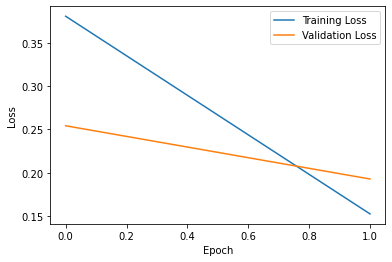

In [197]:
#Plotting the learning curve - (Training Loss, Validation Loss) Vs Epochs
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Testing the Model

In [198]:
# ========== Testing ==========

#Tracking variables 
test_accuracy = []
test_precision = []
test_recall = []
test_f1score = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        
        # Forward pass
        eval_output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
    logits = eval_output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #Calculating test metrics
    b_accuracy = accuracy_score(label_ids, logits.argmax(axis=1))
    b_precision = precision_score(label_ids, logits.argmax(axis=1))
    b_recall = recall_score(label_ids, logits.argmax(axis=1))
    b_f1score = f1_score(label_ids, logits.argmax(axis=1))
    test_accuracy.append(b_accuracy)
    test_precision.append(b_precision)
    test_recall.append(b_recall)
    test_f1score.append(b_f1score)

#Calculating mean of all metrics
test_accuracy = np.mean(test_accuracy)
test_precision = np.mean(test_precision)
test_recall = np.mean(test_recall)
test_f1score = np.mean(test_f1score)

#Printing test metrics
print('Test Accuracy: {:.4f}'.format(test_accuracy))
print('Test Precision: {:.4f}'.format(test_precision))
print('Test Recall: {:.4f}'.format(test_recall))
print('Test F1_Score: {:.4f}\n'.format(test_f1score))

Test Accuracy: 0.9328
Test Precision: 0.9100
Test Recall: 0.9636
Test F1_Score: 0.9339



#Running Predictions

In [192]:
#Enter an input text for prediction
new_sentence = 'Taking black tar is illegal'

#Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

#Applying the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

#Extracting IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

#Forward pass, calculating logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'negative'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  Taking black tar is illegal
Predicted Class:  positive
